# Import Required Libraries

In [ ]:
import os
import random
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from tqdm import tqdm

In [ ]:
!cp -r /content/drive/MyDrive/fashion_data /content/

In [ ]:
images_path = '/content/fashion_data/images'
data_path = '/content/fashion_data/styles.csv'

# Data Pre-Processing

In [ ]:
# Read metadata
df = pd.read_csv(data_path, on_bad_lines='skip')

In [ ]:
# Check for missing values
df[df.isnull().any(axis=1)]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
87,56489,Women,Personal Care,Nails,Nail Polish,Bronze,Spring,2017.0,NaN,Streetwear Ash Nail Polish # 31
92,52029,Unisex,Apparel,Topwear,Rain Jacket,Coffee Brown,Summer,2012.0,NaN,Just Natural Unisex Charcoal Rain Jacket
282,5402,Women,Footwear,Shoes,Sports Shoes,Purple,NaN,2011.0,Sports,Kalenji Ekiden 200 Wn Purple 2011
292,55001,Women,Personal Care,Lips,Lipstick,Pink,Spring,2017.0,NaN,Lakme Absolute Lip Last Day Kiss Lip Colour
479,57563,Women,Personal Care,Lips,Lipstick,Brown,Spring,2017.0,NaN,Lotus Herbals Pure Colours Nutty Brown Lipstic...
...,...,...,...,...,...,...,...,...,...,...
43633,56605,Women,Personal Care,Makeup,Kajal and Eyeliner,Black,Spring,2017.0,NaN,Streetwear Black Eye Liner 01
44079,57715,Women,Personal Care,Lips,Lip Gloss,Red,Spring,2017.0,NaN,Lotus Herbals Seduction Sappy Watermelon Lip G...
44224,43120,Men,Personal Care,Fragrance,Perfume and Body Mist,NaN,Spring,2017.0,NaN,GUESS by Marciano Men Eau De Toilette 50 ml
44227,55045,Women,Personal Care,Lips,Lipstick,Purple,Spring,2017.0,NaN,Lakme Enrich Satins Lipstick 461


In [ ]:
# Check for missing values
df.isna().sum()

,0
id,0
gender,0
masterCategory,0
subCategory,0
articleType,0
baseColour,15
season,21
year,1
usage,317
productDisplayName,7


In [ ]:
# Get rid of them because of their low numbers
cleaned = df.dropna()

# Verify and Check Images & Metadata

In [ ]:
img_ids = cleaned['id'].astype(str).tolist()
existings = [img_id for img_id in tqdm(img_ids, desc="Verifying images")
                     if os.path.exists(os.path.join(images_path, f"{img_id}.jpg"))]
metadata = cleaned[cleaned['id'].astype(str).isin(existings)].reset_index(drop=True)
print(f"Original metadata size: {len(cleaned)}\n")
print(f"Filtered metadata size: {len(metadata)}")

Verifying images: 100%|██████████| 44077/44077 [00:00<00:00, 147678.83it/s]


Original metadata size: 44077

Filtered metadata size: 44072


Image ID: 39157


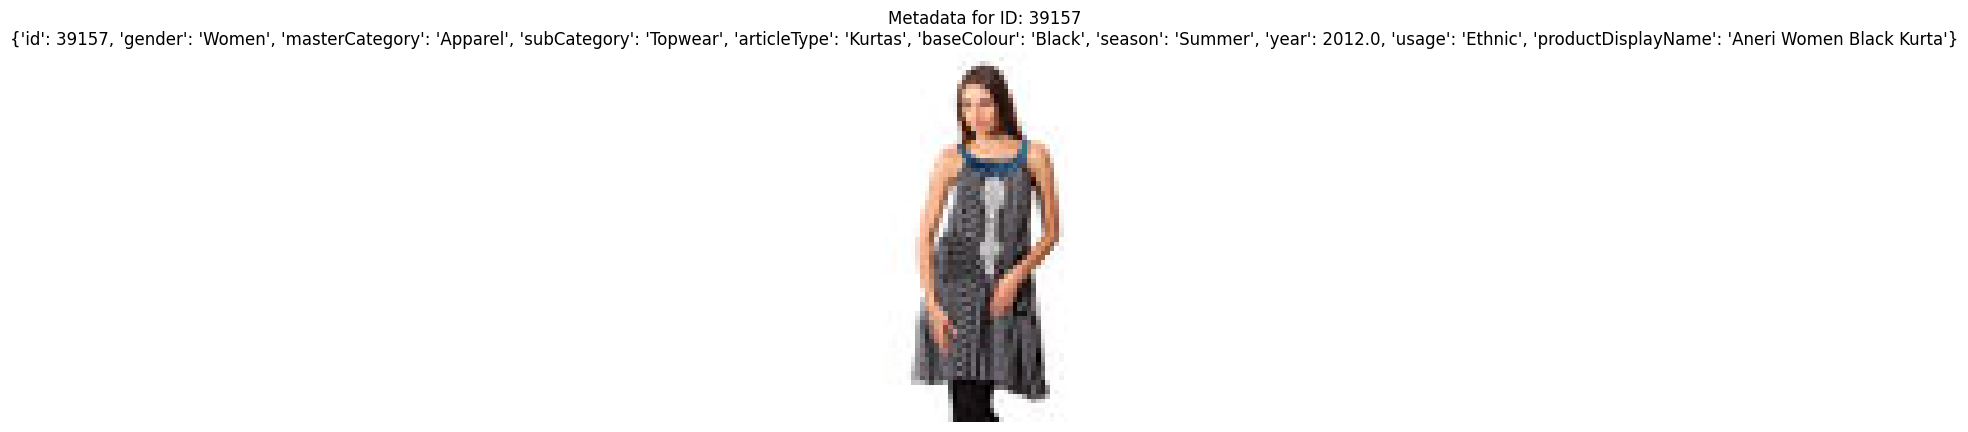

Image ID: 29451


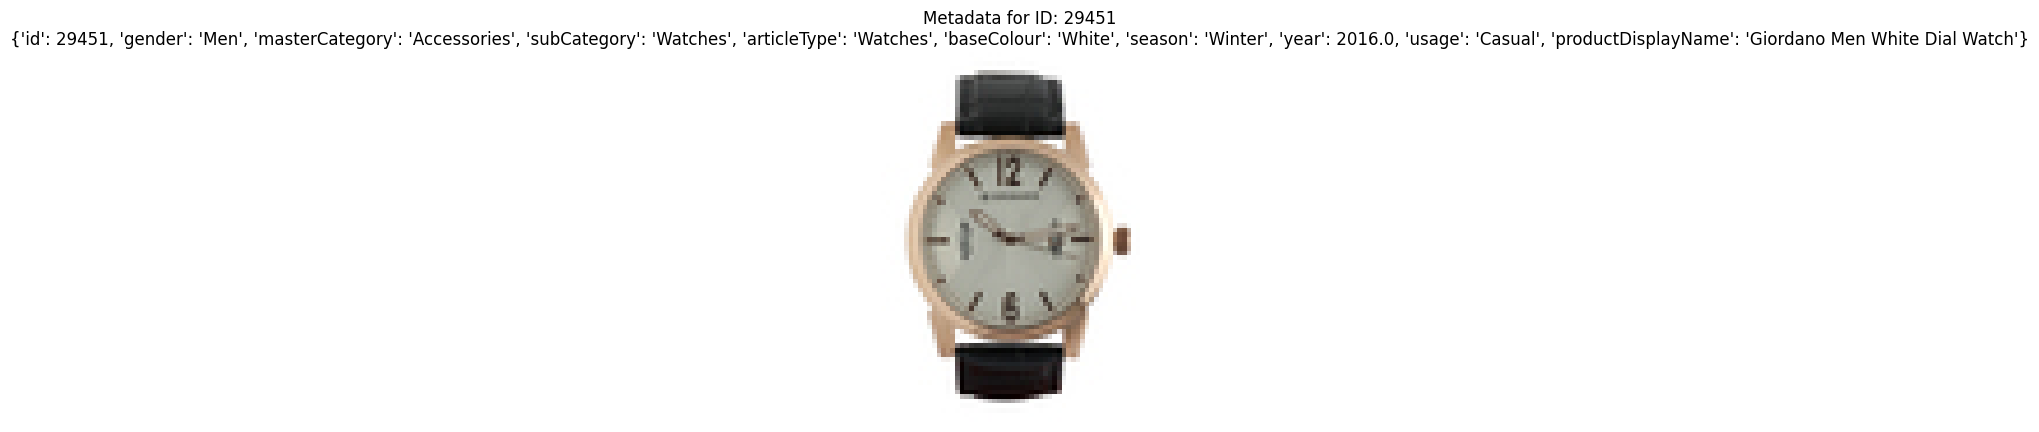

Image ID: 31543


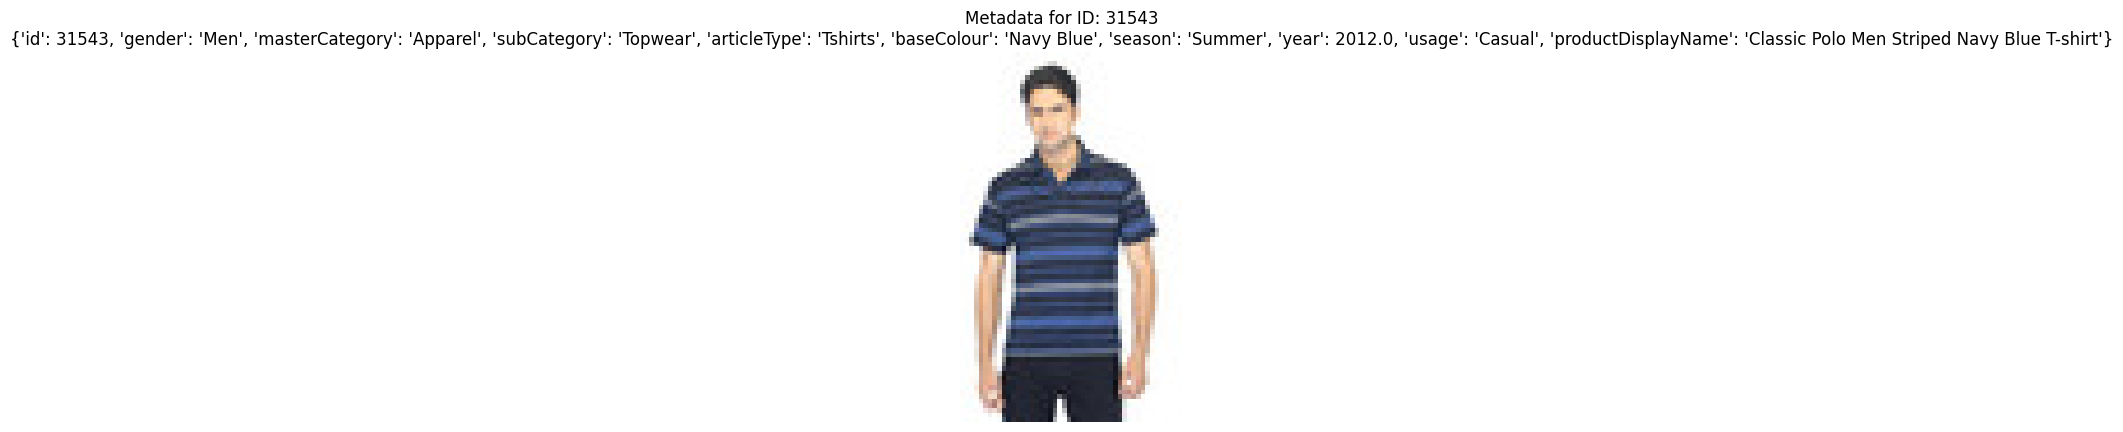

Image ID: 34106


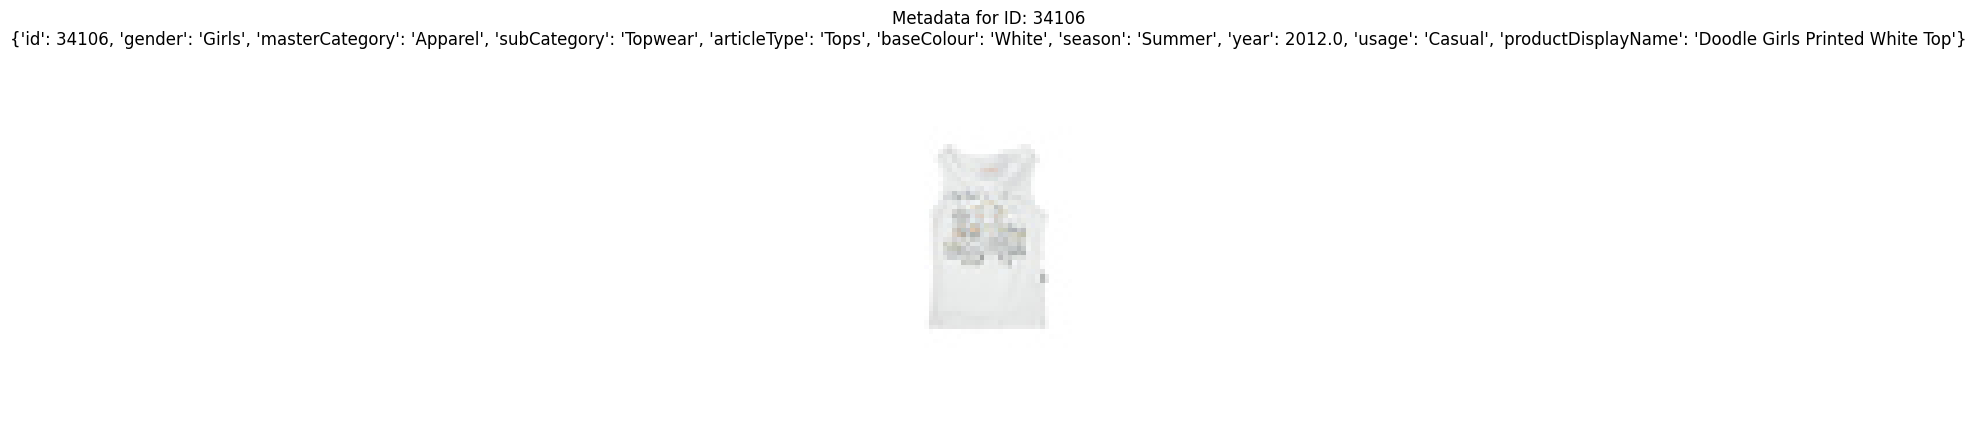

Image ID: 16455


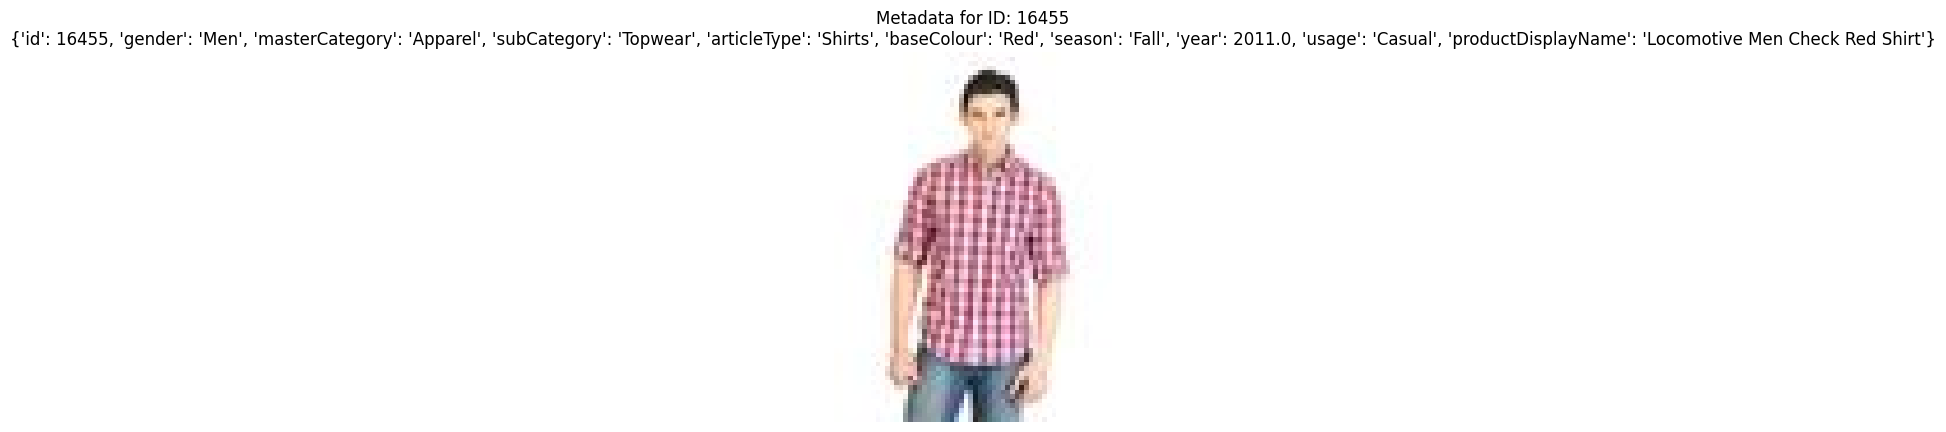

In [ ]:
# Sample and display images with metadata
n = 5
samples = random.sample(existings, min(n, len(existings)))

for img_id in samples:
    print(f"Image ID: {img_id}")
    img_path = os.path.join(images_path, f"{img_id}.jpg")

    row = metadata[metadata['id'].astype(str) == img_id]
    if row.empty:
        print(f"No metadata found for image ID {img_id}")
        continue

    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Metadata for ID: {img_id}\n{row.to_dict(orient='records')[0]}")
    plt.show()

# Encoding

In [ ]:
# Define attributes to predict
attributes = ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage']

# Create label-to-index mappings for each attribute
label2idx_dict = {}
for attr in attributes:
    uniques = metadata[attr].unique()
    label2idx_dict[attr] = {label: idx for idx, label in enumerate(uniques)}

# Compute number of classes for each attribute
classes = [len(label2idx_dict[attr]) for attr in attributes]

# Custom Dataset

In [ ]:
class FashionDataset(Dataset):
    def __init__(self, df, img_dir, attributes, label2idx_dict, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.attributes = attributes
        self.label2idx_dict = label2idx_dict
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id = row['id']
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        image = Image.open(img_path).convert('RGB')
        labels = [self.label2idx_dict[attr][row[attr]] for attr in self.attributes]
        labels = torch.tensor(labels, dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, labels

# Data Transformations

In [ ]:
TARGET_SIZE = (60, 80)
mean = [0.8540, 0.8365, 0.8305]
std = [0.2300, 0.2450, 0.2495]

train_transforms = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Dataset Preparation

In [ ]:
# Set Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
TRAIN_VAL_SPLIT = 0.8
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Create dataset splits
dataset = FashionDataset(metadata, images_path, attributes, label2idx_dict, transform=train_transforms)
data_size = len(dataset)
train_size = int(TRAIN_VAL_SPLIT * data_size)
val_size = data_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transforms

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
# Define Multi-Task Model
class MultiTaskModel(nn.Module):
    def __init__(self, num_classes_list):
        super(MultiTaskModel, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        # Freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.backbone.fc = nn.Identity()  # Remove original fc layer
        # Add classifiers for each attribute
        self.classifiers = nn.ModuleList([
            nn.Linear(2048, num_classes) for num_classes in num_classes_list
        ])

    def forward(self, x):
        features = self.backbone(x)
        features = features.view(features.size(0), -1)  # Flatten
        outputs = [classifier(features) for classifier in self.classifiers]
        return outputs

In [ ]:
# Model Setup
model = MultiTaskModel(classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training Process

In [ ]:
# Training Loop
train_losses = []
for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        losses = [criterion(output, labels[:, i]) for i, output in enumerate(outputs)]
        total_loss = sum(losses)
        total_loss.backward()
        optimizer.step()
        running_loss += total_loss.item() * images.size(0)
    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch}/{NUM_EPOCHS}: Train Loss: {epoch_train_loss:.4f}")

Train Epoch 1: 100%|██████████| 1102/1102 [01:06<00:00, 16.63it/s]


Epoch 1/10: Train Loss: 8.3436


Train Epoch 2: 100%|██████████| 1102/1102 [01:07<00:00, 16.22it/s]


Epoch 2/10: Train Loss: 6.2274


Train Epoch 3: 100%|██████████| 1102/1102 [01:06<00:00, 16.48it/s]


Epoch 3/10: Train Loss: 5.7368


Train Epoch 4: 100%|██████████| 1102/1102 [00:51<00:00, 21.36it/s]


Epoch 4/10: Train Loss: 5.4467


Train Epoch 5: 100%|██████████| 1102/1102 [00:42<00:00, 25.85it/s]


Epoch 5/10: Train Loss: 5.2796


Train Epoch 6: 100%|██████████| 1102/1102 [00:43<00:00, 25.13it/s]


Epoch 6/10: Train Loss: 5.1266


Train Epoch 7: 100%|██████████| 1102/1102 [00:45<00:00, 24.36it/s]


Epoch 7/10: Train Loss: 5.0267


Train Epoch 8: 100%|██████████| 1102/1102 [00:44<00:00, 24.72it/s]


Epoch 8/10: Train Loss: 4.9374


Train Epoch 9: 100%|██████████| 1102/1102 [00:46<00:00, 23.77it/s]


Epoch 9/10: Train Loss: 4.8502


Train Epoch 10: 100%|██████████| 1102/1102 [00:46<00:00, 23.50it/s]

Epoch 10/10: Train Loss: 4.7855


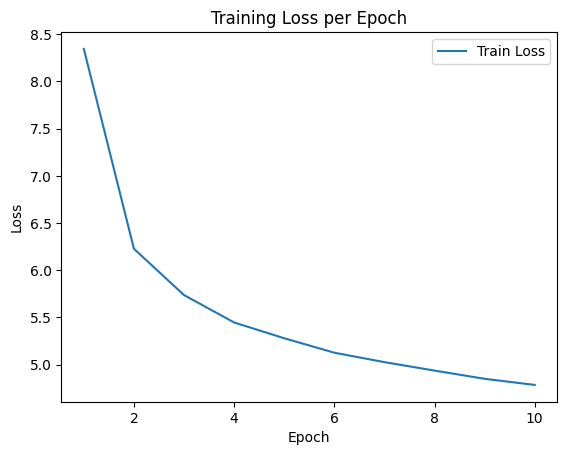

In [ ]:
# Plot training loss
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

# Evaluation

In [ ]:
model.eval()
all_preds = [[] for _ in range(len(attributes))]
all_labels = [[] for _ in range(len(attributes))]
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        for i, output in enumerate(outputs):
            _, preds = output.max(1)
            all_preds[i].extend(preds.cpu().numpy())
            all_labels[i].extend(labels[:, i].cpu().numpy())

Evaluating: 100%|██████████| 276/276 [00:10<00:00, 27.16it/s]


In [ ]:
# Calculate evaluation metrics for each attribute
overall_f1 = 0
for i, attr in enumerate(attributes):
    # Get unique labels present in validation data
    uniques = sorted(list(set(all_labels[i])))
    targets = [list(label2idx_dict[attr].keys())[j] for j in uniques]

    print(f"\nClassification Report for {attr}:")
    report = classification_report(all_labels[i], all_preds[i], labels=uniques, target_names=targets, output_dict=True, zero_division=0)
    print(classification_report(all_labels[i], all_preds[i], labels=uniques, target_names=targets, zero_division=0))
    overall_f1 += report['weighted avg']['f1-score']

# Print overall performance
overall_f1 /= len(attributes)
print(f"\nOverall Weighted F1-Score across all attributes: {overall_f1:.4f}")


Classification Report for gender:
              precision    recall  f1-score   support

         Men       0.78      0.90      0.84      4432
       Women       0.83      0.74      0.78      3693
        Boys       0.66      0.51      0.57       159
       Girls       0.42      0.32      0.36       115
      Unisex       0.62      0.26      0.37       416

    accuracy                           0.79      8815
   macro avg       0.66      0.55      0.59      8815
weighted avg       0.79      0.79      0.78      8815


Classification Report for masterCategory:
                precision    recall  f1-score   support

       Apparel       0.97      0.96      0.97      4287
   Accessories       0.88      0.93      0.90      2210
      Footwear       0.98      0.97      0.97      1859
 Personal Care       0.90      0.79      0.84       431
    Free Items       0.00      0.00      0.00        23
Sporting Goods       0.50      0.20      0.29         5

      accuracy                         